In [1]:
import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv, concat
sns.set_theme(context='notebook', style='white', font_scale=1.33)

import numpy as np
from os.path import dirname
from pandas import read_csv
import pandas as pd
from numba import njit
from tqdm import tqdm
import json
from os.path import exists



#### get samples from stan results

In [2]:
stan_models = ['m1','m2', 'm3', 'm4', 'm5', 'm6']
stan_versions = ['a','b']
sessions = [1, 2, 3]

all_samples = []

for stan_model in stan_models:
    for stan_version in stan_versions:
        for session in sessions:
      
            path_to_file = os.path.join('stan_results', 
                                        f'{stan_model}{stan_version}_s{session}_summary.tsv')
            

            
            if exists(path_to_file):
                
                
                ## summ
                df = read_csv(path_to_file, sep='\t')
                df['model'] = stan_model
                df['session'] = session
                df['version'] = stan_version
                all_samples.append(df)

                

all_samples = concat(all_samples)


In [3]:
all_data = []
for stan_model in stan_models:
    for stan_version in stan_versions:
        for session in sessions:
            path_to_file = os.path.join('stan_results', 'ppc',
                            f'{stan_model}{stan_version}_s{session}_ppc.tsv')
            if exists(path_to_file):
                df = read_csv(path_to_file, sep='\t')
                df['model'] = stan_model
                df['version'] = stan_version
                all_data.append(df)
        
        
all_data = concat(all_data)


In [4]:
#general fit
# all_samples.groupby('model').max()['R_hat']#R_hat.min()
all_samples[all_samples.R_hat>1.02].groupby(['model','version']).count()['R_hat']

model  version
m1     a          179
m3     a            3
m4     a            2
m5     a           26
       b           43
m6     b            1
Name: R_hat, dtype: int64

## match sub id to sub \#

In [5]:
all_ppc = []
for stan_model in stan_models:
    for stan_version in stan_versions:
        for session in sessions:
            path_to_file = os.path.join('stan_results', 'ppc',
                            f'{stan_model}{stan_version}_s{session}_ppc.tsv')
            if exists(path_to_file):
                df = read_csv(path_to_file, sep='\t')
                df['model'] = stan_model
                df['version'] = stan_version
                all_ppc.append(df)
        
        
all_ppc = concat(all_ppc)

In [6]:
subjs = list(set(all_ppc.subject))


## DEBUG M5

In [7]:
all_samples_no_summ_m5=[]
only_model_5 = 'm5'
for stan_version in stan_versions:
    for session in sessions:
        
        path_to_file = os.path.join('stan_results', 
                                        f'{only_model_5}{stan_version}_s{session}.tsv.gz')
        
        if exists(path_to_file):
            StanFit = read_csv(os.path.join('stan_results', f'{only_model_5}{stan_version}_s{session}.tsv.gz'), 
                                       sep='\t', compression='gzip')

            ## all
            StanFit['model'] = only_model_5
            StanFit['session'] = session
            StanFit['version'] = stan_version

            all_samples_no_summ_m5.append(StanFit)


all_samples_no_summ_m5 = concat(all_samples_no_summ_m5)


In [8]:
m5_debug = all_samples.query('model=="m5" and R_hat>1.02')[['name', 'session', 'version']]

samples_to_reivew = m5_debug.name#.str.findall("[0-9]{1,2},[0-9]{1,2}")
# print(samples_to_reivew)

In [12]:
review_a = set(m5_debug[m5_debug.version=='a'].name.tolist())
review_b = set(m5_debug[m5_debug.version=='b'].name.tolist())

# all_samples_no_summ_m5[all_samples_no_summ_m5.version=='a'][review_a].hist(figsize=(20,20))
# plt.show()

# all_samples_no_summ_m5[all_samples_no_summ_m5.version=='b'][review_b].hist(figsize=(20,20))
# plt.show()


,0
176,56
582,2
120,13
121,14
123,16
...,...
187,80
192,85
206,99
418,2


In [64]:
# sub_ids = m5_debug.name.str.split(",").str[-1].str[:-1]
sub_ids = m5_debug.name.str.extract(r'\d.*,(\d.*)]')
sub_ids = sub_ids.dropna()[0]

In [65]:

eta_incong_list = ['eta_incong[{}]'.format(i) for i in sub_ids]
eta_cong_list = ['eta_cong[{}]'.format(i) for i in sub_ids]


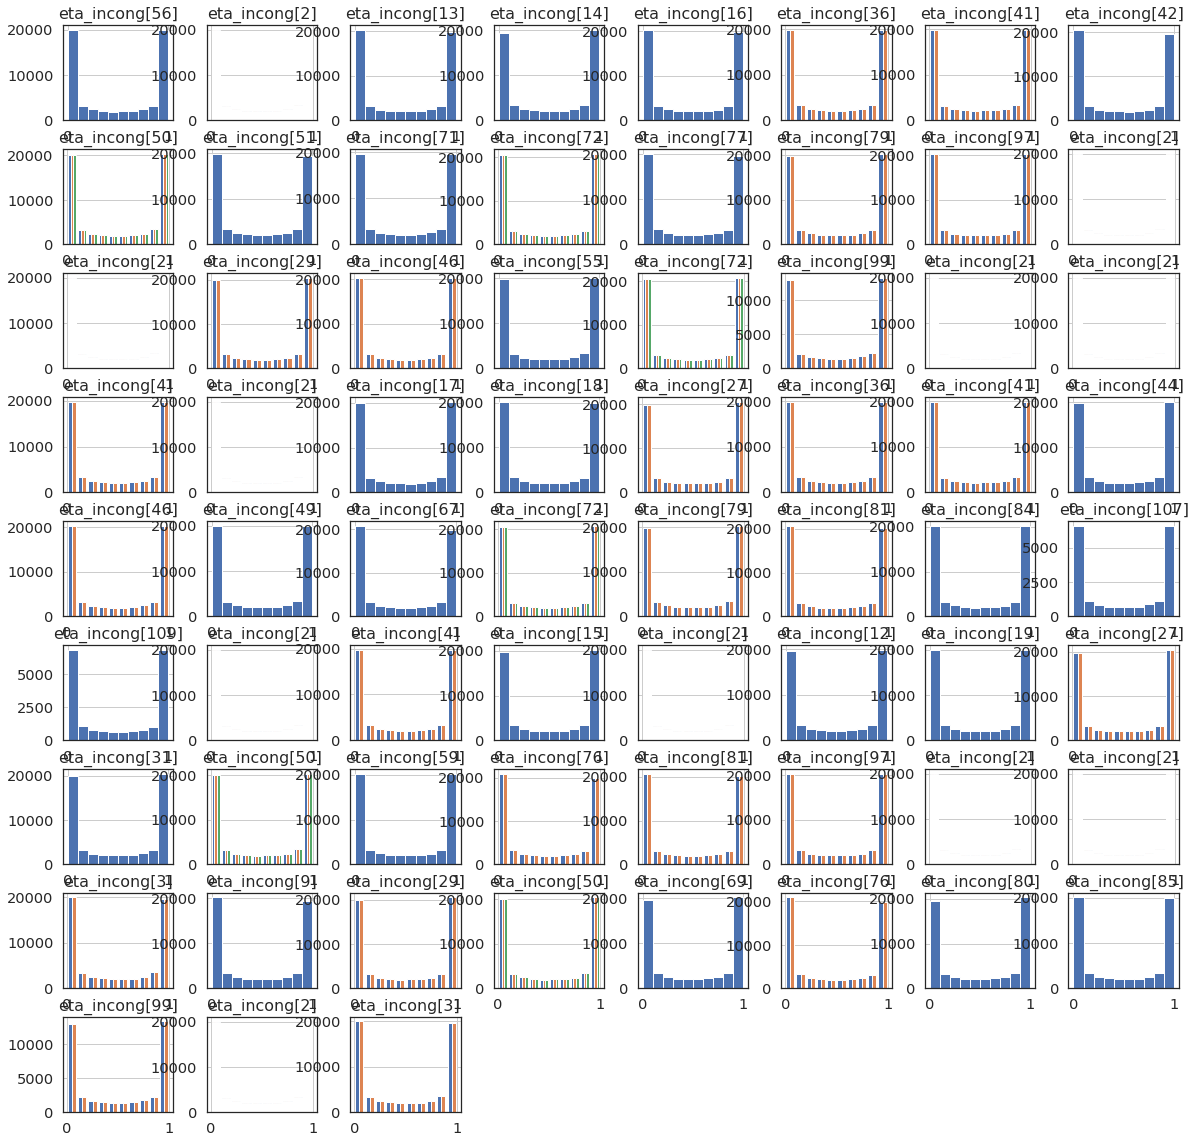

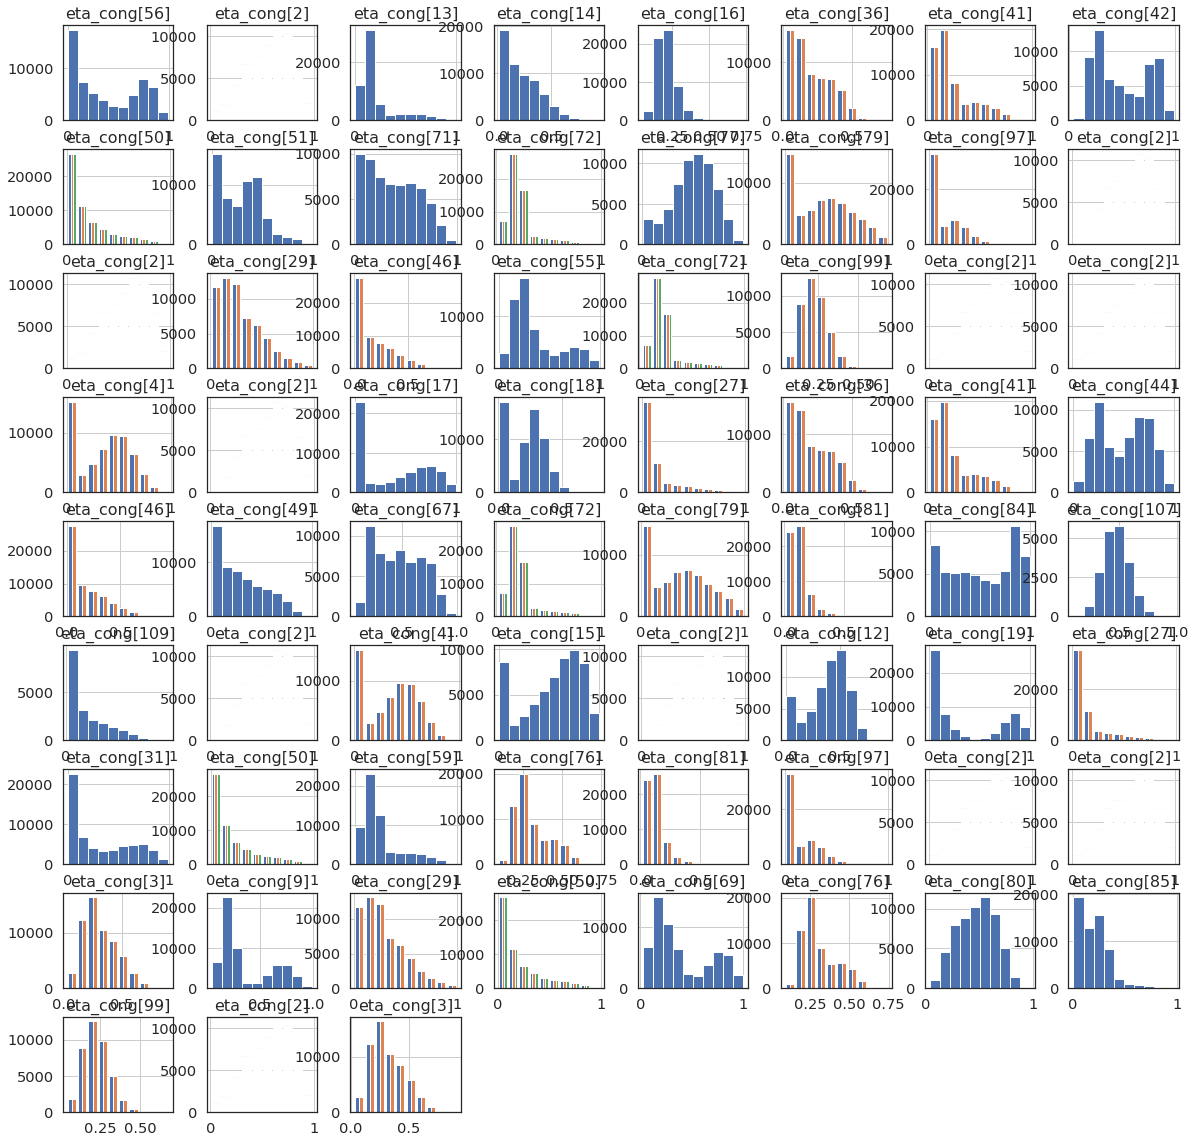

In [66]:
all_samples_no_summ_m5[eta_incong_list].hist(figsize=(20,20))
plt.show()

all_samples_no_summ_m5[eta_cong_list].hist(figsize=(20,20))
plt.show()

In [67]:
subs_to_check = np.array(subjs)[sub_ids.astype(int).to_list()]


In [68]:
all_ppc['debug'] = all_ppc.subject.isin(subs_to_check)

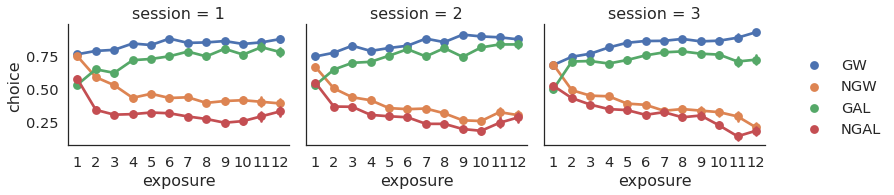

In [72]:
### step by step

g = sns.FacetGrid(all_ppc[all_ppc.debug==True], col='session', 
                  margin_titles=True,
                  col_order=sessions, aspect=1.25, legend_out=True)

order = np.arange(12) + 1
hue_order = ['GW','NGW','GAL','NGAL']

g.map(sns.pointplot, 'exposure', 'choice', 'robot', 
      palette = sns.color_palette(),
      order=order, hue_order=hue_order)

# g.map(sns.pointplot, 'exposure', 'Y_hat', 'robot' , 
#       palette = sns.color_palette("pastel"),
#       order=order, hue_order=hue_order, ci=None, linestyles='--')

g.add_legend()


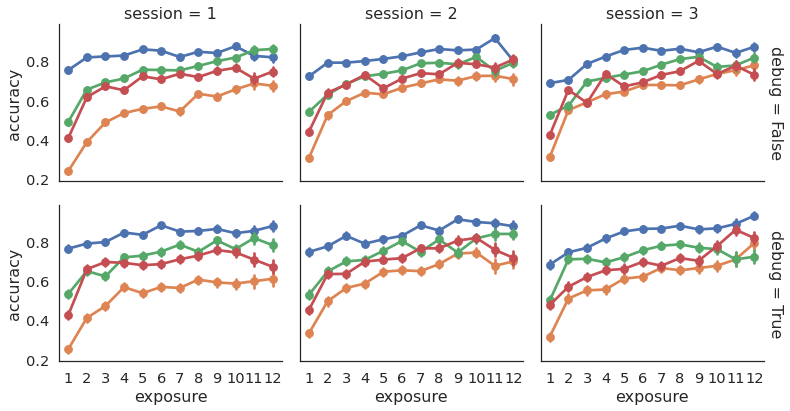

In [70]:
g1 = sns.FacetGrid(all_ppc, col='session', 
                  margin_titles=True, row='debug',
                  col_order=sessions, aspect=1.25, legend_out=True)

order = np.arange(12) + 1
hue_order = ['GW','NGW','GAL','NGAL']

g1.map(sns.pointplot, 'exposure', 'accuracy', 'robot', 
      palette = sns.color_palette(),
      order=order, hue_order=hue_order)

In [ ]:
# all_ppc_a = all_ppc.groupby(['session','subject','robot','exposure','debug']).\
#             agg({'accuracy':'mean'}).reset_index()

In [ ]:
# # g3 = sns.FacetGrid(all_ppc_debug, col='session', 
# #                   margin_titles=True, row='robot',
# #                   col_order=sessions, aspect=1.25, legend_out=True)

# sns.lmplot(
#     data=all_ppc_a,
#     x='exposure', y='accuracy',
#     hue='robot', col="session"a,
#     row='debug',  logx=True,
#     height=5, aspect=.75, facet_kws=dict(sharex=False),
# )




### MODEL 4 LOOKING AT PARAMS

In [7]:
all_samples_no_summ_m4=[]
all_samples_summ_m4=[]

only_model_4 = 'm4'
for stan_version in stan_versions:
    for session in sessions:
        
        path_to_file = os.path.join('stan_results', 
                                        f'{only_model_4}{stan_version}_s{session}.tsv.gz')
        
        if exists(path_to_file):
            StanFit = read_csv(os.path.join('stan_results', f'{only_model_4}{stan_version}_s{session}.tsv.gz'), 
                                       sep='\t', compression='gzip')
            stan_fit_summ = read_csv(os.path.join('stan_results', f'{only_model_4}{stan_version}_s{session}_summary.tsv'), 
                                       sep='\t',)
            ## all
            StanFit['model'] = only_model_4
            StanFit['session'] = session
            StanFit['version'] = stan_version
            
            
            stan_fit_summ['model'] = only_model_4
            stan_fit_summ['session'] = session
            stan_fit_summ['version'] = stan_version

            all_samples_no_summ_m4.append(StanFit)
            all_samples_summ_m4.append(stan_fit_summ)

all_samples_summ_m4=concat(all_samples_summ_m4)            
all_samples_no_summ_m4 = concat(all_samples_no_summ_m4)


In [8]:
# all_samples_no_summ_m4.filter(regex=("eta_gain")).hist(figsize=(20,20))
# plt.show()

# all_samples_no_summ_m4.filter(regex=("eta_loss")).hist(figsize=(20,20))
# plt.show()

In [9]:
# all_samples_summ_m4

## m4b m4a

In [10]:
# all_samples_no_summ_m4[all_samples_no_summ_m4.version=='a'].filter(regex=("beta_GO")).hist(figsize=(20,20))
# plt.show()

# all_samples_no_summ_m4[all_samples_no_summ_m4.version=='a'].filter(regex=("beta_P")).hist(figsize=(20,20))
# plt.show()

In [11]:
# all_samples_no_summ_m4[all_samples_no_summ_m4.version=='b'].filter(regex=("beta_P")).hist(figsize=(20,20))
# plt.show()

In [12]:
# all_samples_summ_m4.name.str.split('[')[0]


all_samples_summ_m4['param_name'] = all_samples_summ_m4.name.str.split('[', expand=True)[0]
all_samples_summ_m4['subj_n'] = all_samples_summ_m4.name.str.split('[', expand=True)[1]
all_samples_summ_m4['subj_n'] = all_samples_summ_m4['subj_n'].str[:-1]

In [13]:
all_samples_summ_m4['subj_ver_ses'] = all_samples_summ_m4['subj_n'] +"_"+ all_samples_summ_m4['version']+"_"+all_samples_summ_m4['session'].astype('str')
all_samples_summ_m4['subj_ses'] = all_samples_summ_m4['subj_n'] +"_"+all_samples_summ_m4['session'].astype('str')


In [14]:
# all_samples_summ_m4.pivot(columns=["param_name",'subj_n',"version",'session'], 
#                           values="Mean")



pivot_t1 = all_samples_summ_m4[all_samples_summ_m4.param_name.isin(['beta_P','beta_GO'])&(all_samples_summ_m4.version=='a')].pivot(index='subj_ver_ses', 
                                                                                     columns=["param_name"], 
                                                                                      values="Mean").reset_index()


pivot_t2 = all_samples_summ_m4[all_samples_summ_m4.param_name.isin(['beta_P'])].pivot(index='subj_ses', 
                                                                                     columns=['version'], 
                                                                                      values="Mean").reset_index()

pivot_t3 = all_samples_summ_m4[all_samples_summ_m4.param_name.isin(['beta_GO'])].pivot(index='subj_ses', 
                                                                                     columns=['version'], 
                                                                                      values="Mean").reset_index()

model 4a


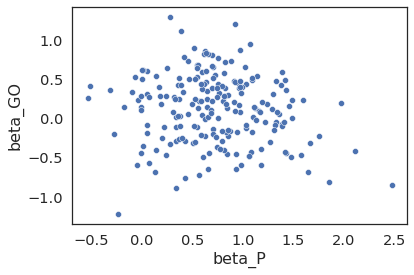

pavlovian bias 4a vs 4b


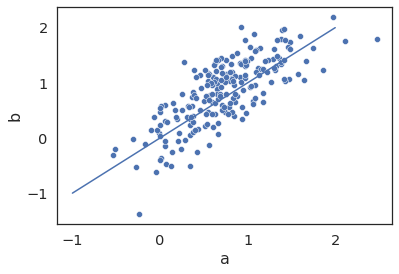

In [18]:
print('model 4a')
sns.scatterplot(data=pivot_t1, x='beta_P', 
                y='beta_GO')

plt.show()
print('pavlovian bias 4a vs 4b')
sns.scatterplot(data=pivot_t2, x='a', 
                y='b')

plt.plot([-1,2],[-1,2])
plt.show()


In [32]:
pivot_t2 = pivot_t2.dropna()
pivot_t1 = pivot_t1.dropna()
sp.stats.pearsonr(pivot_t2['a'],pivot_t2['b'])

(0.7634693697838579, 3.5940878710083915e-41)

<AxesSubplot:>

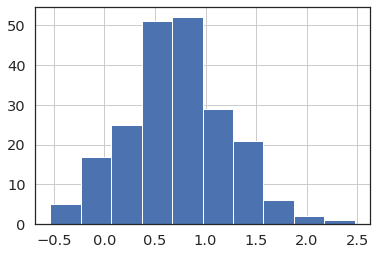

In [35]:
pivot_t1['beta_P'].hist()

In [34]:
##model 4a
print(pivot_t1['beta_P'].mean())
print(pivot_t1['beta_P'].std())

# print(pivot_t1['beta_GO'].mean())
# print(pivot_t1['beta_GO'].std())

# print(pivot_t2['b'].mean())
# print(pivot_t2['b'].std())

0.7263978500191383
0.4889683147228119
0.11832171169377986
0.43644961127427806
0.8428076966507173
0.6009821295095672


In [40]:
# play moment

In [44]:
pivot_t4 = pivot_t2.merge(pivot_t3, how='right', on=['subj_ses'], suffixes=('_b_go', '_b_p'))
pivot_t4['b_b_p'] = pivot_t4['b']
pivot_t4.head()

In [22]:

# from scipy.optimize import curve_fit

# def func(x, a, b):
#     return a*x[0] + b*x[1]

# x0 = pivot_t4['a_b_p']
# x1 = pivot_t4['a_b_go']
# y = pivot_t4['b_b_p']


# popt, pcov = curve_fit(func, [x0,x1], y)
# print(popt, pcov)


In [21]:
# plt.scatter(y, func([x0,x1], *popt))
# plt.scatter(y, x0)
# plt.scatter(y, x1)


##### comapre model 2 and model 3

In [ ]:
p0 = sns.histplot(data=samples_pivot[samples_pivot.model.isin(['m2','m3'])],
                 x='beta',
                  hue='model')

In [ ]:

p1 = sns.jointplot(data=samples_pivot[samples_pivot.model=='m3'], 
              x="beta_GO", 
              y="beta_P")
              #kind="kde")
p1.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)
# p1.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)

_, _, r_value, p_value, _ = sp.stats.linregress(samples_pivot[samples_pivot.model=='m3'].beta_P,
                                              samples_pivot[samples_pivot.model=='m3'].beta_GO)

print('r= ',np.round(r_value,3))




In [ ]:
m2_beta_p = samples_pivot[samples_pivot.model=='m2'][['beta_P','session','subj']]
m3_beta_p = samples_pivot[samples_pivot.model=='m3'][['beta_P','session','subj']]
m2_beta_p
gb_beta_p = pd.merge(m2_beta_p, m3_beta_p, 
         on=['session','subj'], suffixes=('_m2', '_m3'))


In [ ]:
p3 = sns.jointplot(x='beta_P_m2', 
                   y='beta_P_m3', 
                   data=gb_beta_p,
                   kind="reg")

p3.ax_joint.plot([-1, 2.5], [-1, 2.5], 
                 color='grey', 
                 linestyle='--',
                 linewidth = 2)



In [ ]:
_, _, r_value, p_value, _ = sp.stats.linregress(gb_beta_p.beta_P_m2,
                                              gb_beta_p.beta_P_m3)

print('r= ',np.round(r_value,3))
print('p= ',p_value)



In [ ]:
## get subejecst with high b-go

mean_beta_go = samples_pivot[samples_pivot.model=='m3'].groupby('subj').mean()['beta_GO'].reset_index()

mean_beta_go.beta_GO.hist()
above_med_go_subjects = mean_beta_go[mean_beta_go.beta_GO>mean_beta_go.beta_GO.median()].subj.tolist()


with open('analysis_arrays/above_med_go_subjects.npy', 'wb') as f:
    np.save(f, np.array(above_med_go_subjects))
    


In [ ]:
p3_1 = sns.jointplot(x='beta', 
                   y='beta_GO', 
                   data=samples_pivot[samples_pivot.model=='m3'],
                   kind="reg")



In [ ]:
def inv_logit(x):
    return 1. / (1 + np.exp(-x))

inv_logit(0.2) - .5

In [ ]:
########### assym eta

In [ ]:
p4 = sns.jointplot(x='eta_loss', 
                   y='eta_gain', 
                   data=samples_pivot[samples_pivot.model=='m4'],
                   kind="reg")

p4 = sns.jointplot(x='eta_cong', 
                   y='eta_incong', 
                   data=samples_pivot[samples_pivot.model=='m5'],
                   kind="reg")


p4 = sns.jointplot(x='eta_cong', 
                   y='eta_incong', 
                   data=samples_pivot[samples_pivot.model=='m6'],
                   kind="reg")

In [ ]:
# p5 = sns.histplot(x='param',
#         data=samples[samples.param.isin(['eta_loss','eta_gain'])][['param','Mean']])

# # samples
# samples[samples.param.isin(['eta_loss','eta_gain'])][['param','Mean']]

In [ ]:
p5 = sns.histplot(x='eta', hue='model',
                   data=samples_pivot[samples_pivot.model!='m1'])
plt.show()
